# Analyzing the economic impact of the Eras Tour on cities across the United States


In [1]:
import sqlite3 as db
import pandas as pd


## Overview:
This notebook looks at data collected from Taylor Swift's Eras Tour and assesses the economic impact of the tour on cities across the U.S. We will seek to answer the following questions through our data analysis:

- How much money did Swifties contribute to each city's local economy through concert-related expenses?
- How might we determine which cities most benefitted from hosting the Eras Tour, from an economic standpoint?

## Datasets used:

### Table #1: dataset_ts.csv
https://www.kaggle.com/datasets/tymonbot/taylor-swift-eras-toure?resource=download

This table focuses specifically on the Eras Tour. It has the following columns:

- concert_id: a unique id for each concert
- opener_ar1: first artist who opened for that concert (if any)
- opener_ar2: second artist who opened for that concert (if any)
- city: the city where the concert took place
- date: the date of the concert in DD.MM.YYYY format
- tick_sales: number of tickets sold for that concert
- is_mashup_1: Taylor sings two "surprise songs" per concert. Some surprise songs can be mashups of multiple songs, or they can be one individual song. This column will be 'True' if surprise song 1 is a mashup, and 'False' if it is not a mashup.
- surp_1: The title of the first surprise song (or surprise song mashup)
- album_1: The album that the first surprise song is from
- is_mashup_2: This column will be 'True' if surprise song 2 is a mashup, and 'False' if it is not a mashup.
- surp_2: The title of the second surprise song (or surprise song mashup)
- album_2: The album that the second surprise song is from
- cancel: 'True' if the concert was cancelled, 'False' if it proceeded as expected
- cancel_cause: explanation of cancellation, if relevant
- wkt_geom: geographical coordinates of the concert
- place: name of the concert venue
- x: the x coordinate of the concert location
- y: the y coordinate of the concert location

(I have explained each column's title for the sake of thoroughness, but we may not need the information from every single column in this table to demonstrate our point.)

### Table #2: Taylor_Train.csv
https://www.kaggle.com/datasets/gayu14/taylor-concert-tours-impact-on-attendance-and

This table focuses on all of Taylor's tours prior to the Eras Tour. It has the following columns:

- City: the city the concert took place in 
- Country: the country the concert took place in
- Venue: name of the concert venue
- Opening act(s): any artists that opened for Taylor
- Attendance (tickets sold / available): number of tickets sold out of tickets available
- Revenue: total revenue earned from ticket sales
- Tour: which tour the concert was a part of


## Load data:

In [2]:
#Load in the first dataset

df = pd.read_csv('dataset_ts.csv',sep=';',on_bad_lines='skip')
connection = db.connect('demo.db')
table = df.to_sql('taylor_data1',connection,if_exists='replace')


In [3]:
#Load in the second dataset

df2 = pd.read_csv('Taylor_Train.csv',on_bad_lines='skip',encoding='unicode_escape')
connection = db.connect('demo.db')
table = df2.to_sql('taylor_data2',connection,if_exists='replace')


In [4]:
#Let's take a look at the first few rows of the eras tour dataframe (taylor_data1) to see how everything is formatted

query = '''

SELECT *

FROM 'taylor_data1'

LIMIT 8

'''

df2 = pd.read_sql_query(query,connection)
print(df2)

   index  concert_id   opener_ar1     opener_ar2       city        date  \
0      0           1     Paramore          Gayle   Glendale  17.03.2023   
1      1           2     Paramore          Gayle   Glendale  18.03.2023   
2      2           3  Beabadoobee          Gayle  Las Vegas  24.03.2023   
3      3           4  Beabadoobee          Gayle  Las Vegas  25.03.2023   
4      4           5         Muna          Gayle  Arlington  31.03.2023   
5      5           6  Beabadoobee  Gracie Abrams  Arlington  01.04.2023   
6      6           7  Beabadoobee  Gracie Abrams  Arlington  02.04.2023   
7      7           8  Beabadoobee          Gayle      Tampa  13.04.2023   

   tick_sales  is_mashup_1                    surp_1               album_1  \
0       78600            0                Mirrorball              folklore   
1       78600            0         This Is Me Trying              folklore   
2       71835            0                  Our Song  Taylor Swift (debut)   
3       7183

## Revenue calculations:

To start, let's look at the first few rows of the 'other' tours dataframe (taylor_data2) to get an idea of how it's formatted.

In [5]:
query = '''

SELECT *

FROM 'taylor_data2'

LIMIT 8

'''

df2 = pd.read_sql_query(query,connection)
print(df2)

   index              City        Country  \
0      0        Evansville  United States   
1      1         Jonesboro  United States   
2      2         St. Louis  United States   
3      3        Alexandria  United States   
4      4  North Charleston  United States   
5      5      Jacksonville  United States   
6      6            Biloxi  United States   
7      7            London        England   

                                  Venue              Opening act(s)  \
0             Roberts Municipal Stadium  Gloriana\r\nKellie Pickler   
1                    Convocation Center  Gloriana\r\nKellie Pickler   
2                      Scottrade Center  Gloriana\r\nKellie Pickler   
3             Bishop Ireton High School  Gloriana\r\nKellie Pickler   
4             North Charleston Coliseum  Gloriana\r\nKellie Pickler   
5  Jacksonville Veterans Memorial Arena  Gloriana\r\nKellie Pickler   
6            Mississippi Coast Coliseum  Gloriana\r\nKellie Pickler   
7                Shepherd'

Since we don't have data on revenue collected from specific Eras Tour shows yet, we'll have to use one of Taylor's previous tours to figure out our 'average ticket' price. Her reputation stadium tour was the most recent tour prior to the eras tour, so we'll  assume that one will have the most up-to-date prices. We'll query only the shows from taylor_data2 that occurred during the reputation tour. 

In [6]:
query = '''

SELECT City,Country,Revenue, [Attendance (tickets sold / available)] AS tickets

FROM 'taylor_data2'

WHERE Tour='Reputation_Stadium_Tour' AND Country='United States'
'''

df_rep_cities = pd.read_sql_query(query,connection)
print(df_rep_cities.head())

          City        Country      Revenue            tickets
0     Glendale  United States   $7,214,478    59,157 / 59,157
1  Santa Clara  United States  $14,006,963  107,550 / 107,550
2  Santa Clara  United States  $14,006,963  107,550 / 107,550
3     Pasadena  United States  $16,251,980  118,084 / 118,084
4     Pasadena  United States  $16,251,980  118,084 / 118,084


Notice that the tickets column above is formatted as tickets_sold / tickets_available. Since we're only interested in the tickets sold, we need to slice that string. We should also fix the formatting of the revenue column.

In [7]:
df_rep2 = df_rep_cities.copy()

df_rep2['tickets'] = df_rep2['tickets'].astype(str).str.split('/').str[0].str.strip().str.replace(',','').astype(int)

df_rep2['Revenue'] = df_rep2['Revenue'].astype(str).str[1:].str.replace(',','').astype(int)

print(df_rep2.head())

          City        Country   Revenue  tickets
0     Glendale  United States   7214478    59157
1  Santa Clara  United States  14006963   107550
2  Santa Clara  United States  14006963   107550
3     Pasadena  United States  16251980   118084
4     Pasadena  United States  16251980   118084


To find the average ticket price for each city, we need to find the sum of all the revenue earned in a particular city, then divide it by the total number of tickets sold in that city. Since there were multiple shows played in some cities, there may be multiple rows per city. Then we'll take the average of ALL the cities' average ticket price to get one average ticket price for the entire tour.

In [8]:
df_rep3 = df_rep2.groupby(['City']).agg(total_revenue=('Revenue','sum'),total_tickets=('tickets','sum'))
df_rep3['rev_per_ticket'] = (df_rep3['total_revenue']/df_rep3['total_tickets']).round(2)
print(df_rep3.head())

mean_rev = df_rep3['rev_per_ticket'].mean().round(2)
print(mean_rev)


           total_revenue  total_tickets  rev_per_ticket
City                                                   
Arlington       30012314         210004          142.91
Atlanta         36178830         233492          154.95
Chicago         29153394         210416          138.55
Cleveland        5148757          51323          100.32
Columbus         6606529          62897          105.04
127.81


Let's estimate the sales tax that each fan would've paid for each ticket purchase. We'll assume a 7% sales tax rate. Also,
it's important to remember that the calculations thus far have been based on REVENUE collected by the tour, not the actual ticket price a fan would've paid. (ie the revenue is what money would've remained from the 'list price' after sales tax was subtracted)

In [9]:
#formula for sales tax:
#(list_price - 0.07*list_price) = mean_rev
list_price = mean_rev/0.93
sales_tax = (list_price - mean_rev).round(2)


print(sales_tax)

9.62


Now let's query our eras tour dataframe. We need to narrow it down to just the shows played in the US, since we're focusing in on the economic impact that the tour had on US cities. This brings us to a slight inconvenience: the Eras Tour datasheet doesn't include a countries column, so we can't just use a group by. Instead, we'll need to use a nested query referencing the prior tours datasheet, since it actually does include a country column. Any cities that weren't apart of both the eras tour and the reputation tour will be excluded from our investigation. (Just a good learning opportunity that sometimes we aren't given perfect/ideal data and have to make decisions or assumptions for ourselves.)

In [10]:
query = '''

SELECT city, SUM(tick_sales) AS total_tickets, COUNT(city) AS num_shows

FROM 'taylor_data1'

WHERE EXISTS (

    SELECT *
    
    FROM 'taylor_data2'
    
    WHERE taylor_data1.city=taylor_data2.city AND taylor_data2.Country='United States'
)

GROUP BY city

'''

taylor_cities = pd.read_sql_query(query,connection)
print(taylor_cities)

               city  total_tickets  num_shows
0         Arlington         315000          3
1           Atlanta         225000          3
2           Chicago         186000          3
3        Cincinnati         132000          2
4            Denver         168000          2
5           Detroit         156000          2
6   East Rutherford         267000          3
7        Foxborough         198000          3
8          Glendale         157200          2
9           Houston         240000          3
10     Indianapolis         210000          3
11      Kansas City         154000          2
12      Los Angeles         601440          6
13            Miami         195000          3
14      Minneapolis         146000          2
15        Nashville         210000          3
16      New Orleans         249000          3
17     Philadelphia         210000          3
18       Pittsburgh         150000          2
19      Santa Clara         138000          2
20          Seattle         144000

It's estimated that swifties spent somewhere between 974 and 1550 dollars on concert-related purchases like transportation, food, accommodations, and merchandise. Using an average of that, plus the average ticket price we calculated earlier, let's figure out how much Taylor earned on her tour and how much the local community earned.

In [11]:
df_final = taylor_cities.copy()
df_final['total_taxes'] = df_final['total_tickets']*sales_tax
df_final['swiftie_expenses'] = df_final['total_tickets']*1262
df_final['taylors_revenue'] = df_final['total_tickets']*mean_rev
df_final['local_revenue'] = df_final['total_taxes']+df_final['swiftie_expenses']
df_final = df_final.sort_values(by='local_revenue',ascending=False)


print(df_final)

               city  total_tickets  num_shows  total_taxes  swiftie_expenses  \
12      Los Angeles         601440          6    5785852.8         759017280   
0         Arlington         315000          3    3030300.0         397530000   
6   East Rutherford         267000          3    2568540.0         336954000   
16      New Orleans         249000          3    2395380.0         314238000   
9           Houston         240000          3    2308800.0         302880000   
1           Atlanta         225000          3    2164500.0         283950000   
21            Tampa         225000          3    2164500.0         283950000   
10     Indianapolis         210000          3    2020200.0         265020000   
15        Nashville         210000          3    2020200.0         265020000   
17     Philadelphia         210000          3    2020200.0         265020000   
7        Foxborough         198000          3    1904760.0         249876000   
13            Miami         195000      

Text(0, 0.5, 'taxes in millions')

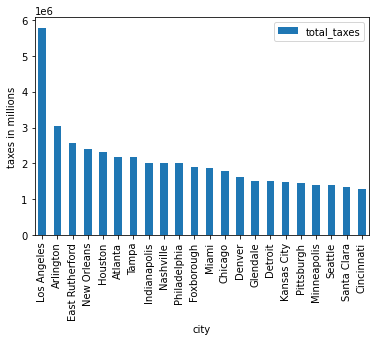

In [12]:
df_final.plot(x='city',y='total_taxes',kind='bar').set_ylabel('taxes in millions')

Text(0, 0.5, 'expenses in hundred millions')

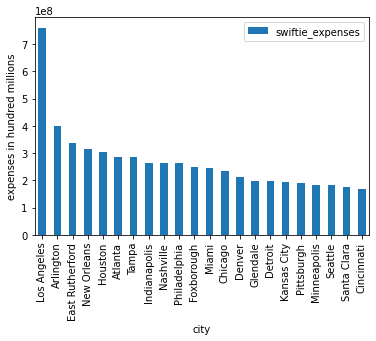

In [13]:
df_final.plot(x='city',y='swiftie_expenses',kind='bar').set_ylabel('expenses in hundred millions')

Text(0, 0.5, 'revenue in hundred millions')

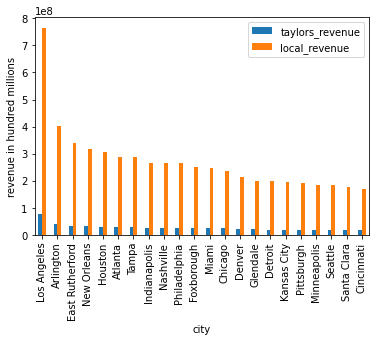

In [14]:
df_final.plot(x='city',y=['taylors_revenue','local_revenue'],kind='bar').set_ylabel('revenue in hundred millions')

## Conclusions
With the Eras Tour only just recently being completed and more facts and figures continuing to be published, it's hard to know how accurate these findings are; however, the city of Cincinatti did release their own economic projections prior to Taylor's shows there which we can use as a point of reference. Their reported state tax earnings were actually extremely close to ours: 1.4 million (their figure) vs. 1.2 million (our figure). That being said, there was a greater difference between our findings for 'Swiftie expenses' or money contributed to the local economy through non-tax means: 48 million (their figure) vs. 167 million (our figure). One possible explanation for this is the difference is that it's difficult to accurately calculate what percentage of fans were local, and would've spent on the lower end of the estimated range, versus what percentage were travelling in from far away and would've had more concert-specific expenses. There could also be a relationship between how much a fan was willing to spend on their tickets and whether or not they were travelling in from out of town. If so, that relationship wouldn't be reflected in our calculations because we only used one "average" ticket price. That being said, our calculation for Denver was far closer to the actual reported projection: 140 million (their figure) vs. 212 million (our figure) in 'Swiftie expenses.' It could be that this process is simply too city-specific to try and use the same parameters for each stop on the tour. As more information becomes available, we could use it to make more accurate predictions, but one thing is clear: in every city Taylor visited, she likely contributed vastly more to the local economy than her tour actually brought in. (If our calculations are anything to go by, around 10x more than what her tour actually collected in revenue went to the host city's economy.) According to our calculations, the cities that benefited most from the tour are those that had the most shows and sold the most tickets at those shows: Los Angeles, Arlington, East Rutherford, New Orleans, and Houston.

### Future considerations:
- Although using an average 'Swiftie expense' figure of 1267 per concert attendee does seem reasonable given the statistics available, it would be better to break those expenses down into specific cost areas, like accommodations, food, travel, etc. and try to segment concertgoers into "locals" and "out-of-towners." As seen in the figure below about short-term rental revenue, fans were much more likely to travel into town for concerts that were considered 'significant stops' on the tour, such as the opening and closing shows, as well as Taylor's show in Nashville, given that she is a former country artist.
- Another interesting phenomenon to take note of is that according to hotel data, not only was there an obvious spike in revenue during the weekend of an eras show, but there was also a 9% increase in revenue and 10% increase in occupancy the weekend prior to an eras show. It would be worth investigating whether this occupancy was also concert-related and if the revenue was reported.

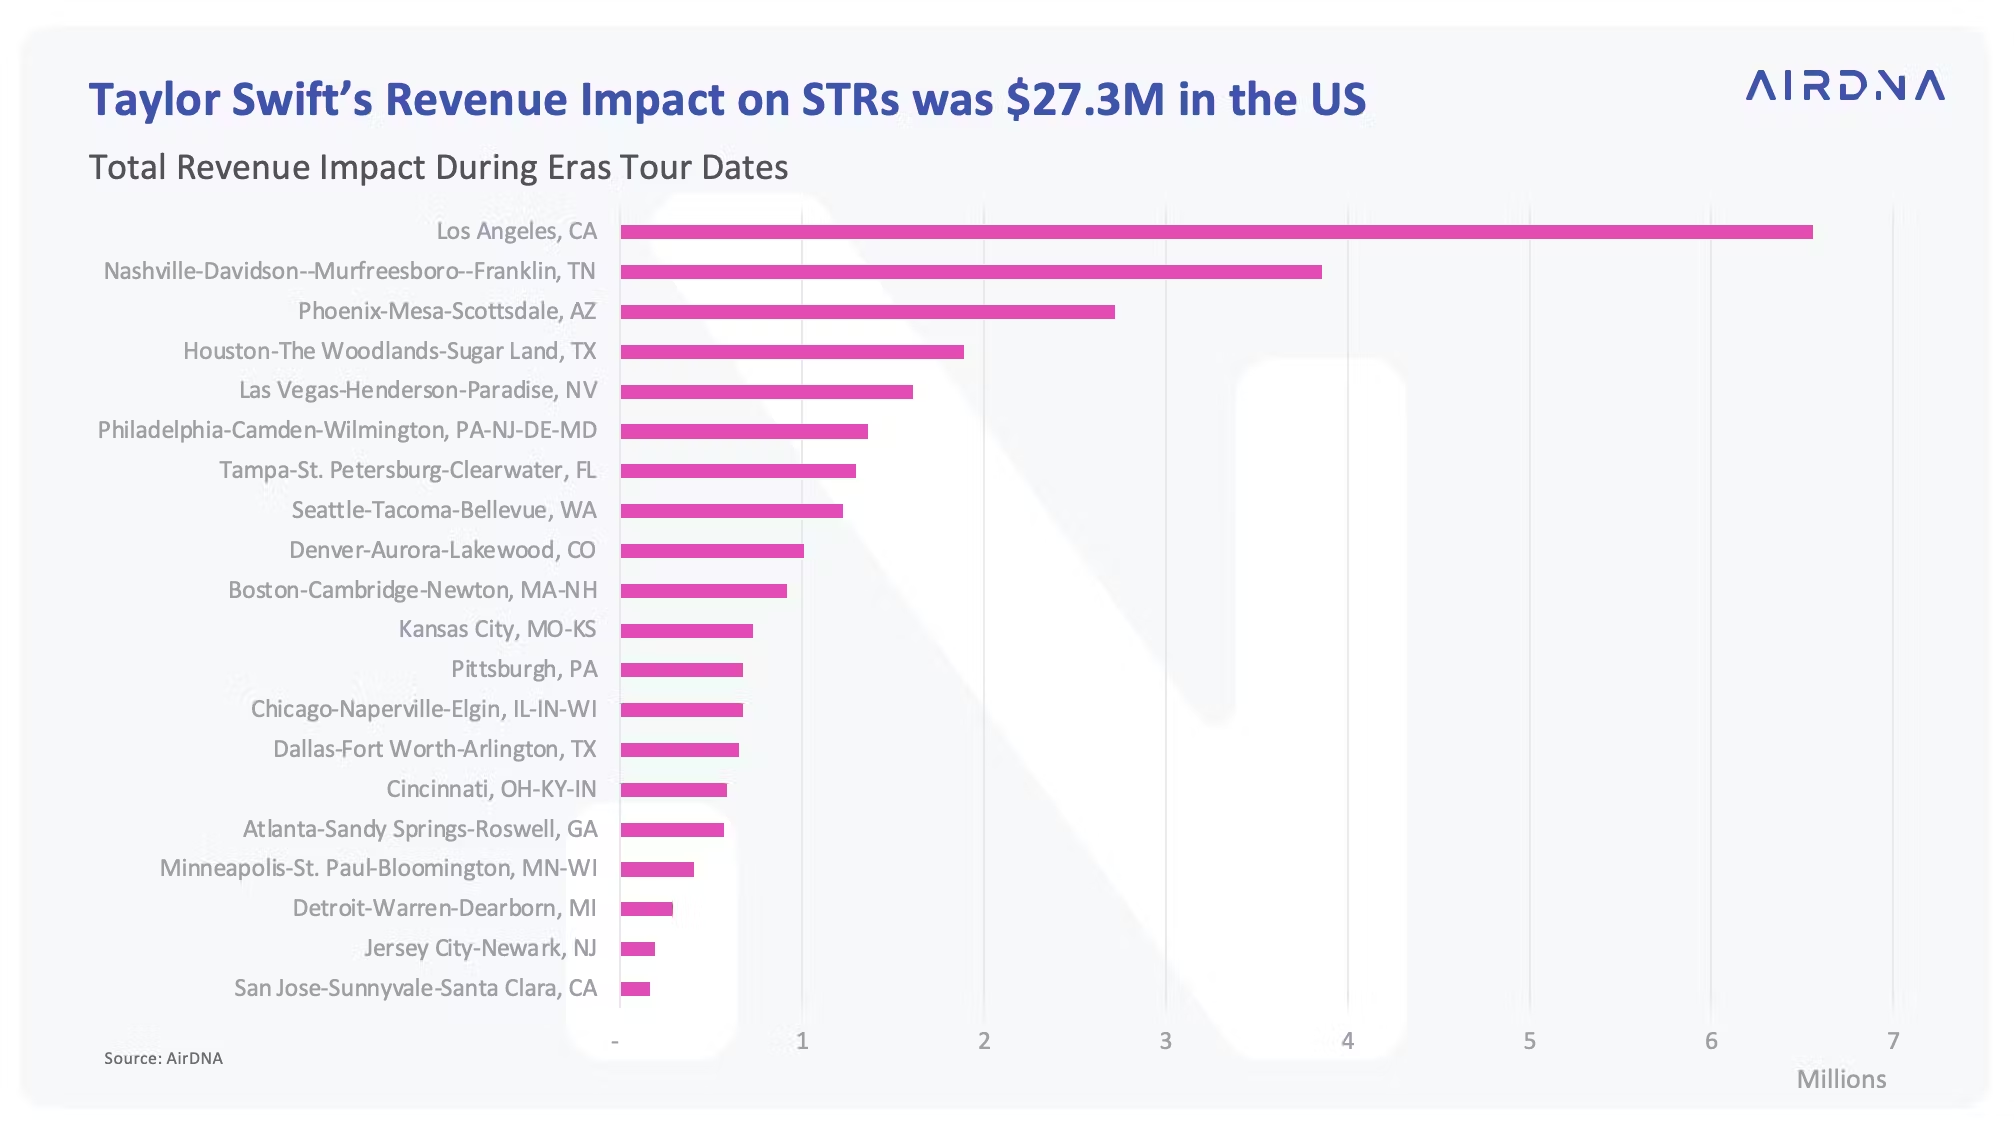

https://www.airdna.co/blog/taylor-swift-transforms-local-economies-str-market

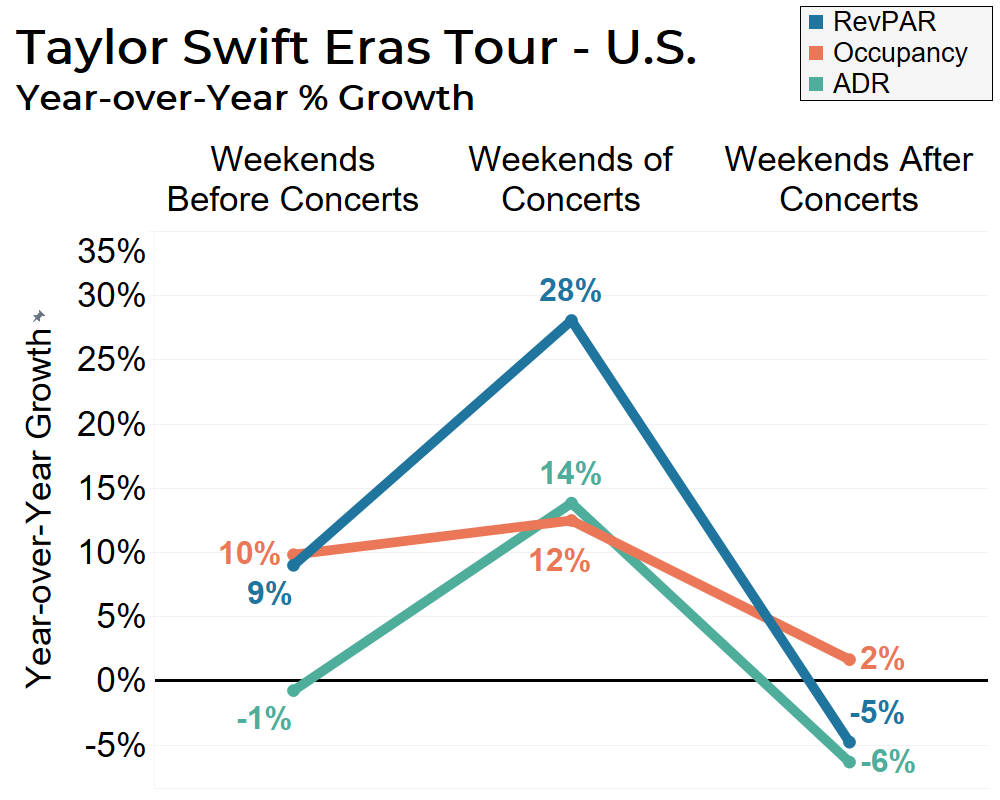

https://www.keydatadashboard.com/blog/hospitality-spikes-from-taylor-swifts-u-s-eras-tour